# Analysis of Neural Networks by computing saliency maps (see e.g. https://www.sciencedirect.com/topics/engineering/saliency-map)

In [1]:
os.chdir("..") # You should now be in the 'drought_impact_forecasting' folder
os.getcwd()

'/Users/klaus-rudolfkladny/Documents/ETH_Zurich/3.Semester/DS_lab/drought_impact_forecasting'

In [2]:
import numpy as np
import torch

In [3]:
from load_model_data import load_data_point, load_model
from draw_forecast import visualize_rgb
from time_ndvi_plot import plot_ndvi

Load two trained models.

In [4]:
SGConvLSTM = load_model("trained_models/SGConvLSTM.ckpt")
SGEDConvLSTM = load_model("trained_models/SGEDConvLSTM.ckpt")

Load an example from the extreme data set.

In [83]:
truth, context, target, npf = load_data_point(test_context_dataset = "Data/small_data/extreme_context_data_paths.pkl", 
                                            test_target_dataset = "Data/small_data/extreme_target_data_paths.pkl",
                                            index = 1)

These lines are important for autograd to know that we want the gradient with respect to the context!

In [84]:
context_SG = context.clone().requires_grad_()
context_SGED = context.clone().requires_grad_()

We can now run inference. This may take a while.

In [85]:
# Run inference (can be slow) 
prediction_SG, _, _ = SGConvLSTM(x = context_SG, prediction_count = int((2/3)*truth.shape[-1]), non_pred_feat = npf)
prediction_SGED, _, _ = SGEDConvLSTM(x = context_SGED, prediction_count = int((2/3)*truth.shape[-1]), non_pred_feat = npf)

We want the response to be the mean NDVI of e.g. the last image. For this, we can define a function.

In [86]:
def mean_NDVI(prediction):
    # compute NDVI 
    ndvi = ((prediction[:, 3, ...] - prediction[ :, 2, ...]) / (
                prediction[:, 3, ...] + prediction[:, 2, ...] + 1e-6))
    return torch.mean(ndvi[0, :, :, 0])

In [87]:
prediction_mean_ndvi_SG = mean_NDVI(prediction_SG)
prediction_mean_ndvi_SGED = mean_NDVI(prediction_SGED)

Time to backpropagate. Again, this can take a while.

In [88]:
g_SG = torch.autograd.grad(prediction_mean_ndvi_SG, context_SG)

In [111]:
g_SGED = torch.autograd.grad(prediction_mean_ndvi_SGED, context_SGED)

Finally, we can visualize the desired maps.

In [89]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [4, 4]
plt.rcParams['figure.dpi'] = 90

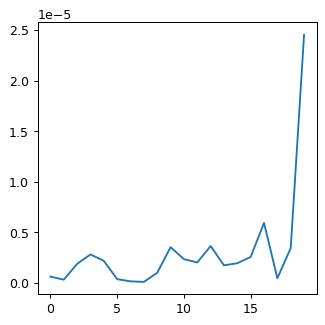

In [116]:
plt.plot(torch.abs(torch.mean(g_SG[0][0, 6, :, :, :], dim=(0, 1))))

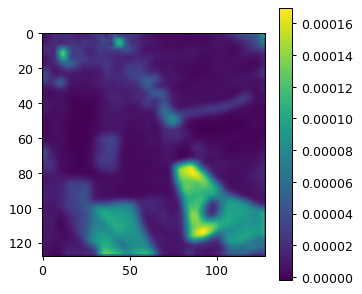

In [120]:
plt.imshow((g_SG[0][0, 6, :, :, 19]).permute(1, 0))
plt.colorbar()